## Rock Paper Scissors image classification on ESP32 Board
#### Rayan Malik (100063470) and Wahaj Ahmed (100063485)

In this tutorial, we aim to train an image classification model, and use an ESP32 microcomputer board for inference. We go through the hardware and software configuration of the board, as well as the process to create a Tensorflow Lite model suitable for the limited hardware available. 


#### 1) Hardware configuration
 First, connect the ESP32-CAM to the ESP-32-CAM-MB daughterboard. This daughterboard adds usb-to-serial interfacing to the ESP32 board, making it convenient to upload and debug our work. Then, connect the camera module to the ESP32-CAM board via the ribbon connector on it's top side. 
The end result should look something like this: 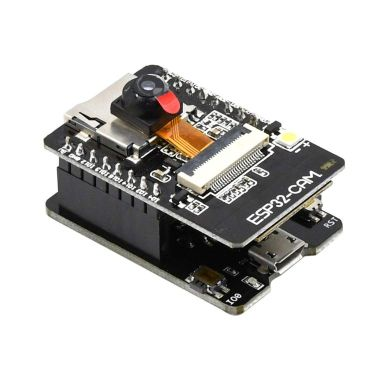

#### 2) IDE configuration 
 Download the latest Arduino IDE. Install the ESP32 board packages here: https://raw.githubusercontent.com/espressif/arduino-esp32/gh-pages/package_esp32_index.json. Then, select AI Thinker ESP32-CAM from Tools > Board > Board Manager.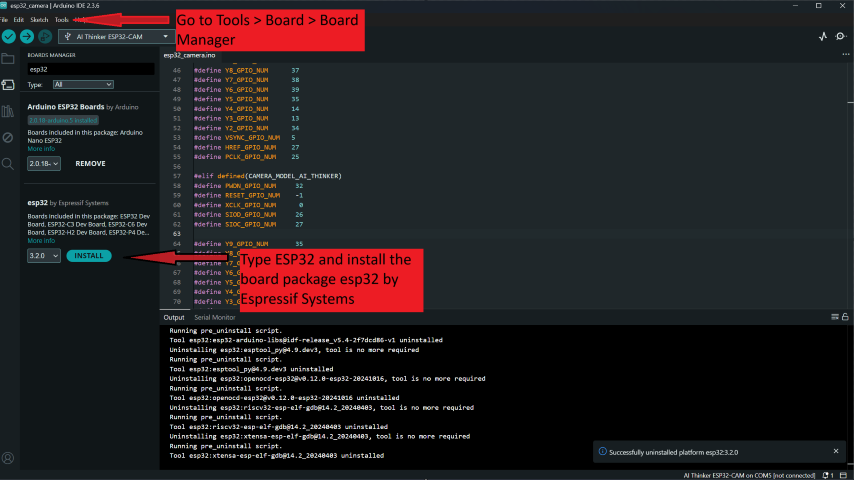
 Install the drivers for the CH340 usb to serial converter used in the ESP32-CAM-MB daughterboard here: https://learn.sparkfun.com/tutorials/how-to-install-ch340-drivers/all. Optionally, you can verify your hardware configuration by going to File > Examples > ESP32 > Camera Web Server and uploading the sketch to the ESP32. De-comment the camera define for the AI-Thinker board variant, and add your Wi-Fi credentials to the sketch first. You may need to do the following procedure on first upload if you encounter a "Port does not exist" error:
- Hold down the BOOT button on the ESP32-CAM-MB daughterboard.
- Whilst holding it down, press and release the RST button.
- Release the BOOT button and upload.

To view the output of the camera in real-time, open the serial monitor, set the Baud Rate to 115,200, and press the RST button on the daughterboard. The ESP32 will print an IP address to serial monitor. You can view the real-time camera feed by opening the address on a browser. 

#### 3) Model training
The ESP32-CAM chip comes with 4MB of flash. In order to work within this limiting factor, our model must be highly optimised with as few parameters as possible. Therefore, we turn to Edge Impulse, an online edge AI development platform. In order to connect our ESP32 board to Edge Studio, we must do some configuration first:

Download and install Python 3.1: https://www.python.org/download/releases/3.1/ 
1) Download and install ESPtool via the following commands in terminal: ```python -m pip install pyserial >=  3.4``` and ```python -mpip install esptool >= 3.3```p
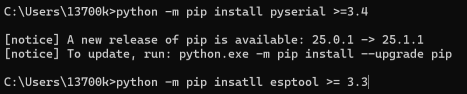
3) Flash the ESP32 with modified ESP-EYE firmware to enable compatability with Edge. The firmware can be found here: https://github.com/Mjrovai/ESP32-TinyML/blob/main/ESP32-CAM_Code/espressif-esp32-cam-ai-thinker.zip
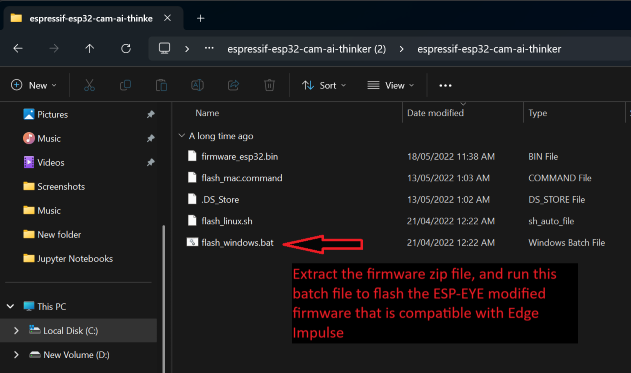
5) To setup Edge CLI, first create an account at edgeimpulse.com. Install Node.js here: https://nodejs.org/en/. Make sure to select the Tools for Native Modules option when installing Node Js: 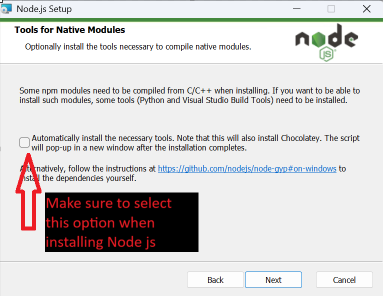 Then, run the following command in terminal: ```npm install -g edge-impulse-cli --force```. Disregard any soft warning regarding the use of --force. 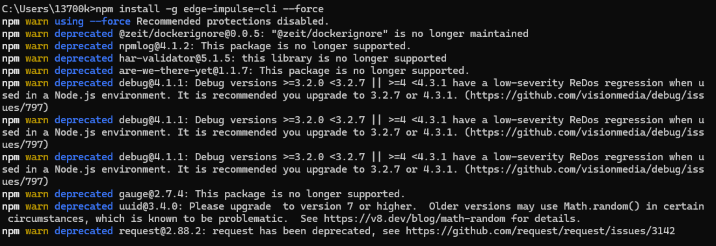
6) AFter setting up Edge Impulse CLI, we now have all the required tools to connect our ESP32 board to Edge Impulse Studio. Connect the board with a micro-usb cable to your computer. Then, open terminal again and run ```edge-impulse-daemon```. Enter your account credentials, and the board should automatically be linked to your last created project.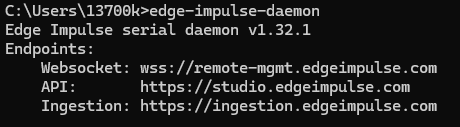

The benefit of connecting the board directly to impulse studio is that we can take additional photos for our dataset from the camera of the ESP32 itself. This will theoretically prevent overfitting our model to a dataset recorded on different camera. 

Once you have connected ESP32 to Edge Studio, go to data acquisition and begin uploading your training data. First, select training, choose a label and add it's corresponding folder, and upload. Do this for all three classes, and then repeat the process for testing. You can optionally add some samples from the ESP32's camera here to reduce overfitting. 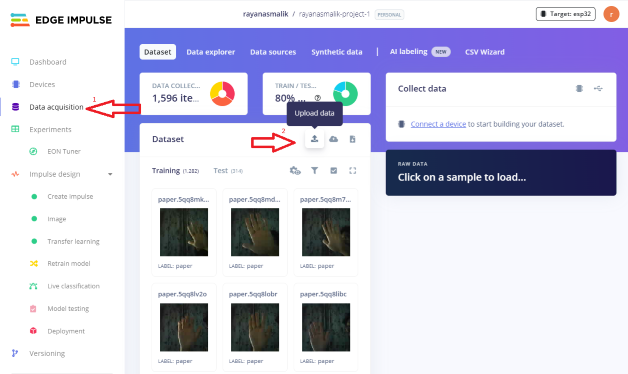
###### Go to Data Acquisition > upload data.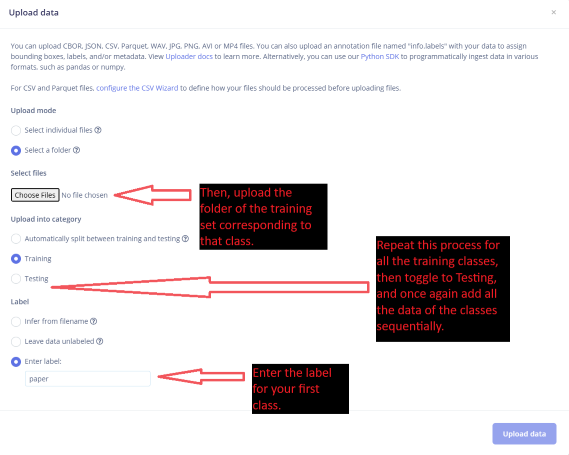 Upload the training data, class by class, and then do the same for the testing data.

After uploading your dataset from Kaggle or what have you, you can now add photos directly taken from the camera of the ESP32. Make sure to label them correctly. 

After that, create an impulse. Set image data to ```(96, 96)``` and add a processing block Image with input axis ```image```. Add a transfer learning block and save your impulse. 
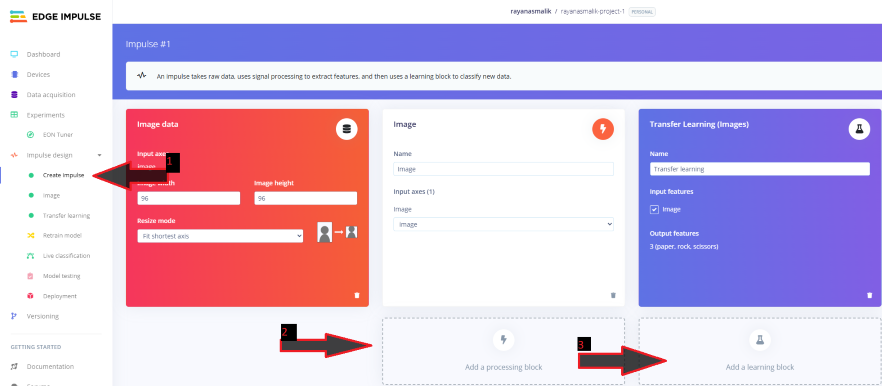
The blocks you defined in your impulse should now appear on the left hand column. Open the Image block and change the Image input's color depth to Grayscale, then save parameters. You should also get the option to perform feature generation at this point, which will convert the dataset from (300,300,3) to (96,96,1).
!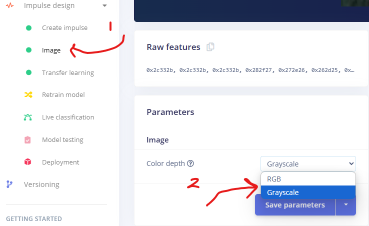

Now, go to transfer learning, again in the column to the left. The best model to perform transfer learning from is MobileNetV2, and I was able to use learning rate 0.0005 without the model getting too big to upload on the ESP32. Make sure to check the data augmentation option. Once you train the model, go to deployment. 

By default, Quantized int8 should be selected. Change the library from C++ to Arduino Library and build. You should get a .zip file; go to the Arduino IDE, Sketch > Include Library > Add .zip library and select your exported model. Now go to File > Examples > Examples from Custom libraries (at the bottom) and choose your project > esp32 > esp32_camera. Change the define from CAMERA_MODEL_ESP_EYE to CAMERA_MODEL_AI_THINKER. Upload to the board. You should see real-time classification occuring in the serial monitor, with metrics such as time taken for digital signal processing (applying grayscale and changing image resolution), and time taken for inference. 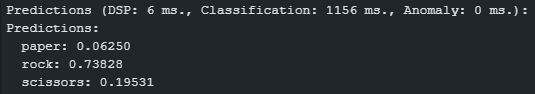 

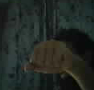

Due to the limited hardware, developing a truly accurate model with strong generality and high accuracy is difficult. I noticed that the classification's results were highly pose and lighting dependent. However, with the right lighting and poses, it was generally delivering strong predictions, with the correct class hovering at 0.7 to 0.9 probablity. 

##### 4) Conclusion:
With more time, it would certainly be possible to develop an image classification model with more generality and higher accuracy. Under the time constraints of this assignment, I believe the fact that we were able to get a model up and running in the first place is a testament to the excellent software and hardware stack available for Edge AI development on the ESP32. It is worth mentioning that at first, I tried a different approach to the Edge Impulse one. I found an off the shelf model with extremely high accuracy on kaggle, verified it's efficacy in real-time by classifying inputs from my webcam, and attempted to use that model for transfer learning. Unfortunately, the model was far too large (112MB) for any reasonable way to get it under 4 MB, even with quantisation and transfer learning from an 8 layer deep model to a 3 layer deep one. Hence, I scratched that approach and chose a small dataset with a good selection of unique poses to get the best result possible.

If one was to approach this project with more time, it would be prudent to do the following to improve inference accuracy:
1) Take more photos on the ESP32's camera for the dataset. I only had time to take around 10 or so for each class; perhaps if one took 100 or so they could avoid overfitting to a large dataset.
2) Experiment with different training rates. Again, due to time limitations I was unable to experiment with lots of different training rates.

Credits: Lots of inspiration was taken from this guide by Marcelo Rovai, available on hackster.io: https://www.hackster.io/mjrobot/esp32-cam-tinyml-image-classification-fruits-vs-veggies-4ab970#comments 